In [0]:
# Import libraries
import pandas as pd
import numpy as np
import math
import sys
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Read raw dataset directly from CSSEGISandData repository 

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)


In [0]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,174,187,208,208,208,208,208,220,235,235,235,235,246,251,251,251,251,251,251,299,441,443,458,463,479,483,484,484,484,485,499,499,513,513,514,611,632,639,659,661
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,25,34,34,51,56,65,70,85,106,122,128,130,167,184,197,209,212,222,233,249,256,278,283,310,323,354,399,419,453,469,482,484,496,524,560,591,632,705,728
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,8,8,11,11,11,11,11,11,11,11,11,11,11,34,34,78,78,87,87,87,87,87,87,106,106,106,132,132,132,132,141,141,141,141,162,162,163,176,176
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,379,461,522,612,612,661,729,801,907,1118,1322,1524,1729,1936,2140,2350,2551,2738,2929,3100,3266,3424,3563,3686,3807,3930,4013,4100,4191,4289,4370,4453,4529,4609,4690,4763,4834,4902,4971,5035


In [0]:
# Shift the time series so day 0 correspond to the first infection for each 
# country 
data = df.values
time_series = []
for country in data:
  days = [];
  for i in range(4,len(country)):
    if country[i] != 0:
        days.append(country[i])
  time_series.append(days)



In [0]:
# DTW function: Calculate the distance of two time series

def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))

    # Initialization of the dtw matrix
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    # Calculating the elements of the dtw matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min

    return dtw_matrix[n,m]

In [0]:
# Progress Bar function

def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

In [0]:
# Distance matrix for the countries 
n = len(data)
m = (n,n)
distance_matrix = np.zeros(m)
print("This is going to take a while to calculate.")
for i in range(n):
    for j in range(n):
        # Calculating the distances of the lower triangular matrix because the 
        # distances of the upper triangular can be directly calculated from the 
        # respective distances of the lower triangular
        if(i < j):  
            distance_matrix[i][j] = dtw(time_series[i],time_series[j])
        else:
            distance_matrix[i][j] = distance_matrix[j][i]
    printProgressBar(i,n,"Progress")


In [0]:
distance_matrix

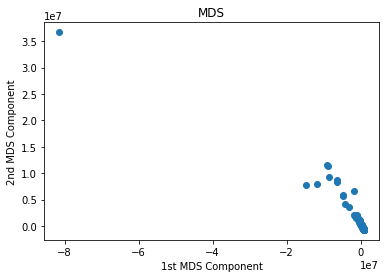

In [0]:
# Visualization of the countries' distances with MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
mds_result = model.fit_transform(distance_matrix)
x = mds_result[:,0]
y = mds_result[:,1]
plt.scatter(x,y)
plt.ylabel('2nd MDS Component')
plt.xlabel('1st MDS Component')
plt.title('MDS')
plt.show()


The best result was 0.927715 for 3 clusters.


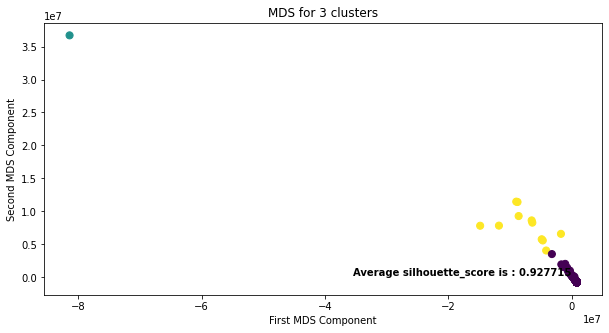

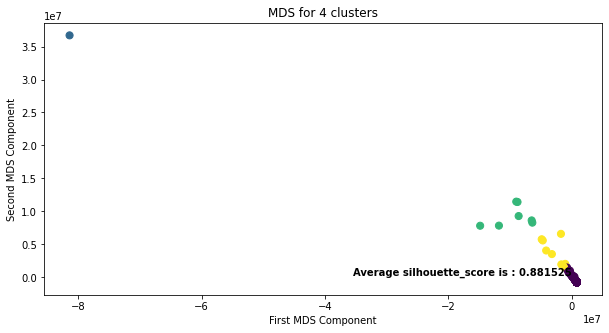

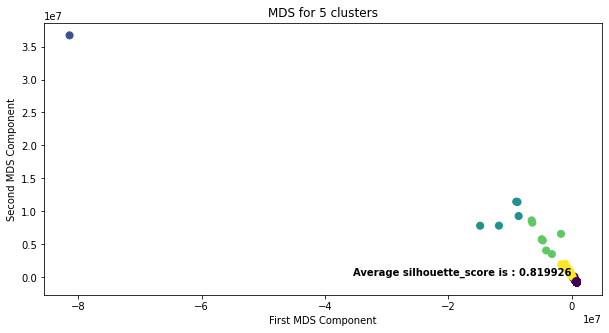

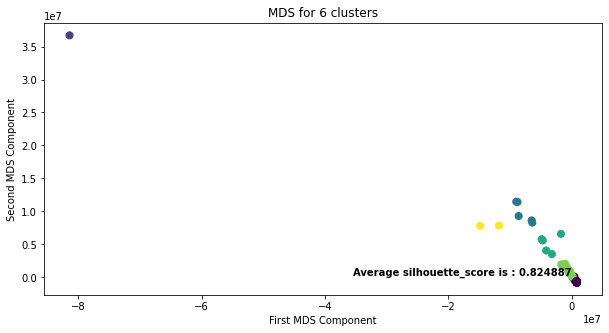

In [0]:
# K-Means clustering with Outliers and Silhouette score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

best = 0.0 
index = 0  
for cluster_number in range(3,7):
  kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(mds_result)
  kmeans.labels_
  y_kmeans = kmeans.predict(mds_result)
  silhouette_mean = silhouette_score(mds_result, kmeans.labels_)
  text = ("Average silhouette_score is : %lf" % silhouette_mean)

  plt.figure(figsize=(10,5))
  plt.text( 0, 0 , text, horizontalalignment='right',
           verticalalignment='bottom', weight='bold')
  plt.scatter(x, y, c=y_kmeans, s=50, cmap='viridis')
  plt.ylabel('Second MDS Component')
  plt.xlabel('First MDS Component')
  plt.title('MDS for %d clusters' % cluster_number)
  if(best < silhouette_mean):
    best = silhouette_mean
    index = cluster_number
    best_cluster_with_outliers = y_kmeans

print("The best result was %lf for %d clusters." % (best, index))

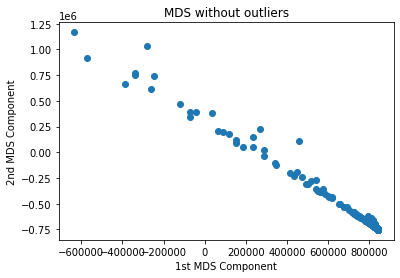

19 countries were removed.


In [0]:
from scipy import stats

# Procedure to find and eliminate outliers 
mds_without_outliers = mds_result[(np.abs(stats.zscore(mds_result)) < 0.5).all(axis=1)]
x1 = mds_without_outliers[:,0]
y1 = mds_without_outliers[:,1]
plt.scatter(x1,y1)
plt.ylabel('2nd MDS Component')
plt.xlabel('1st MDS Component')
plt.title('MDS without outliers')
plt.show()

print("%d countries were removed." % (mds_result.shape[0] - mds_without_outliers.shape[0]))

The best result without outlier was 0.803142 for 3 clusters.


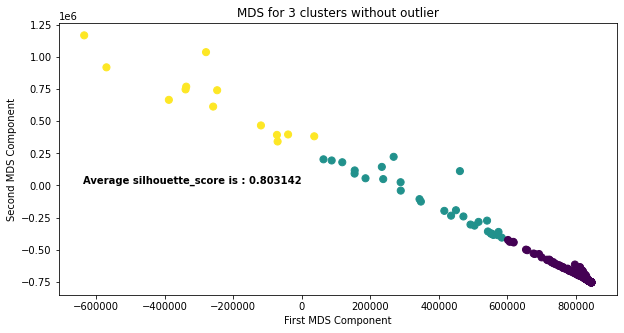

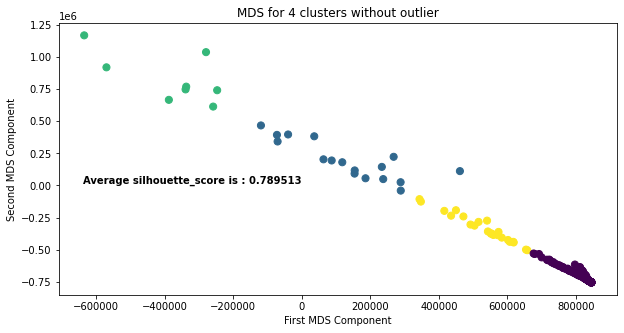

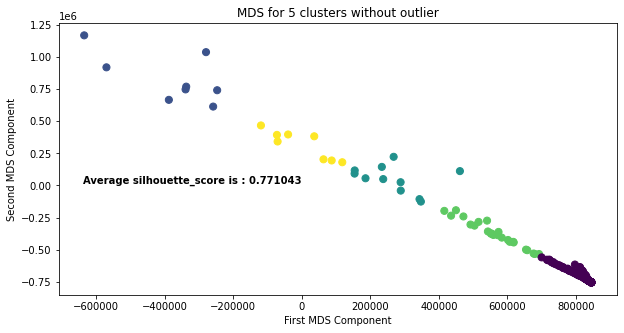

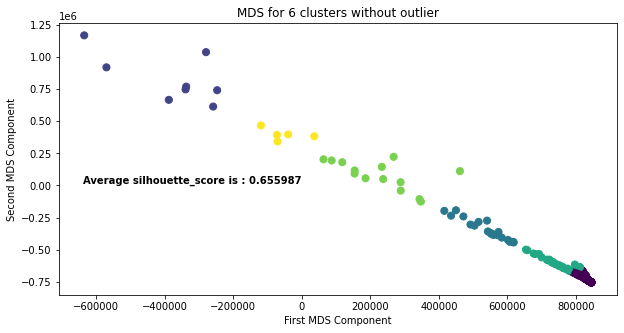

In [0]:
# K-Means clustering without Outliers and Silhouette score
best = 0.0 
index = 0  
for cluster_number in range(3,7):
  kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(mds_without_outliers)
  kmeans.labels_
  y_kmeans1 = kmeans.predict(mds_without_outliers)
  silhouette_mean = silhouette_score(mds_without_outliers, kmeans.labels_)
  text = ("Average silhouette_score is : %lf" % silhouette_mean)
  
  plt.figure(figsize=(10,5))
  plt.text( 0, 0 , text, horizontalalignment='right',
           verticalalignment='bottom', weight='bold')

  plt.scatter(x1, y1, c=y_kmeans1, s=50, cmap='viridis')
  plt.ylabel('Second MDS Component')
  plt.xlabel('First MDS Component')
  plt.title('MDS for %d clusters without outlier' % cluster_number)
  if(best < silhouette_mean):
    best = silhouette_mean
    index = cluster_number
    best_cluster_without_outliers = y_kmeans1
    
print("The best result without outlier was %lf for %d clusters." % (best, index))


In [0]:
# Add the countries' names in clusters according to the best model regarding silhouette evaluation.
# Best model accoring to silhouette evaluation was for 3 clusters without 
# outlier detection
cluster_A = []
cluster_B = []
cluster_C = []

for i in range(len(data)):
  value = ("%s - %s" % (data[i][0], data[i][1]))
  if(best_cluster_with_outliers[i] == 0):
    cluster_A.append(value)
  elif(best_cluster_with_outliers[i] == 1): 
    cluster_B.append(value)
  else:
    cluster_C.append(value)


In [0]:
# Print cluster A
cluster_A

['nan - Afghanistan',
 'nan - Albania',
 'nan - Algeria',
 'nan - Andorra',
 'nan - Angola',
 'nan - Antigua and Barbuda',
 'nan - Argentina',
 'nan - Armenia',
 'Australian Capital Territory - Australia',
 'New South Wales - Australia',
 'Northern Territory - Australia',
 'Queensland - Australia',
 'South Australia - Australia',
 'Tasmania - Australia',
 'Victoria - Australia',
 'Western Australia - Australia',
 'nan - Austria',
 'nan - Azerbaijan',
 'nan - Bahamas',
 'nan - Bahrain',
 'nan - Bangladesh',
 'nan - Barbados',
 'nan - Belarus',
 'nan - Belgium',
 'nan - Benin',
 'nan - Bhutan',
 'nan - Bolivia',
 'nan - Bosnia and Herzegovina',
 'nan - Brunei',
 'nan - Bulgaria',
 'nan - Burkina Faso',
 'nan - Cabo Verde',
 'nan - Cambodia',
 'nan - Cameroon',
 'Alberta - Canada',
 'British Columbia - Canada',
 'Grand Princess - Canada',
 'Manitoba - Canada',
 'New Brunswick - Canada',
 'Newfoundland and Labrador - Canada',
 'Nova Scotia - Canada',
 'Ontario - Canada',
 'Prince Edward Is

In [0]:
# Print cluster B
cluster_B 

['nan - US']

In [0]:
# Print cluster C
cluster_C

['nan - Brazil',
 'Hubei - China',
 'nan - France',
 'nan - Germany',
 'nan - India',
 'nan - Iran',
 'nan - Italy',
 'nan - Russia',
 'nan - Spain',
 'nan - Turkey',
 'nan - United Kingdom']